# Biofysikk prosjekt

In [2]:
import numpy as np
import numba as nb
from numba import njit, jit, int32
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

#### Oppgave 1 Grunnleggende polymer-funksjonalitet
a)
Vi har valgt å representere hvert polymer som et N x 2 array. Polymeren er satt sammen av flere monomerer, der hvert element i polymer-arrayet er en monomer. (Seinere bruker vi kooordinaten til elementet i polymer-arrayet til å representere polymeren og monomerene i et kartesisk koordinatsystem???). 

Det er også mulig å representere et polymer av lengden N i et array av dimensjon M x M, der M => N. De resterende plassene i M x M arrayet, som ikke illustrer en monomer, ville vært representert av nullere. Dette ville vært overflødig data som vi ikke trenger for å arbeide videre med polymeren. Ved å lagre masse nullere, som vi ikke er avhegning av for å løse oppgavene, vil koden bli betydelig treigere.

Dermed har vi valgt å jobbe med et N x 2 array for å unngå overflødig lagring av data, og oppnå raskest mulig kjøretid. 


(Finne ut hvor mye raskere/hvor mye midre tid dette tar).

In [3]:
N = 7  # Lengde på polymer
M = 9  # Gitterdimensjon

#Definerer først polymer som er et Nx2 array med datatype 32 bit
def init_polymer(N):
    polymer = np.zeros((N, 2), dtype=np.int32)
    polymer[:, 1] = np.arange(N) #np.arange(N)
    polymer[:, 0] = M // 2
    return polymer

init_polymer(N)

array([[4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [4, 6]], dtype=int32)

c) Når vi skal velge hvilket monomer som polymeret skal roteres rundt, så velges dette tilfeldig. Noe som er verdt å merke seg da er at dersom et polymer skal roteres om et endepunkt, så vil det ikke endre noe og polymeren vil forbli i ro. Dette er fordi vi med fordel har valgt at det alltid er den korte enden som skal roteres. Siden energien bestemmes av formen til polymeren, og den forblir uendret ved rotasjon om endemonomer, så vil energien også forbli uendret. Det vil altså hverken oppstå eller forsvinne noen vekselvirkninger mellom monomerer. Dette medfører at det vil være hensiksmessig å ikke inkludere endemonomerene i det tilfeldige utvalget monomeren trekkes fra. Vi vil derfor kun trekke fra 1 til N-1 i arrayet når vi skal velge hvilket monomer som skal roteres rundt. Dette vil være for å minimere kjøretiden til koden, siden den slipper å kjøre gjennom unødvendige steg. 

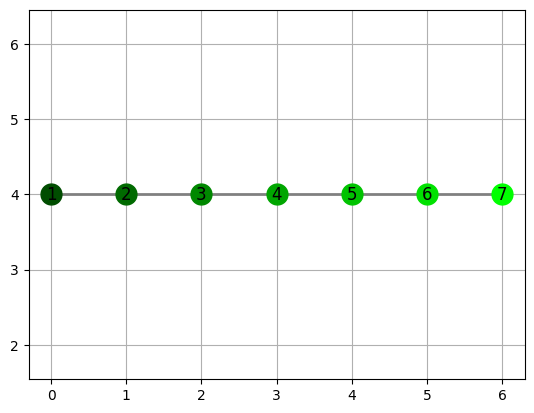

In [6]:
#d)
"""
def plot_polymer(polymer):
    plt.plot(polymer[:, 1], -polymer[:, 0], 'o-') # fortegn?? -polymer eller uten polymer
    plt.axis('equal')
    plt.show()
"""

def plot_polymer(polymer):
    # Assuming 'polymer' is an Nx2 numpy array
    plt.figure()
    num_points = polymer.shape[0]

    # Generating different shades of green
    greens = np.linspace(0.3, 1, num_points)  # Adjust the range for different shades
    colors = [(0, green, 0, 1) for green in greens]  # RGB tuples with varying green component

    # Plot the lines first
    plt.plot(polymer[:, 1], polymer[:, 0], 'o-', color='grey', markersize=10, linewidth=2)

    # Now plot each point and its number
    for i in range(num_points):
        # Plot each point with a different color
        plt.plot(polymer[i, 1], polymer[i, 0], 'o', color=colors[i], markersize=15)

        # Centering the number on the dot
        plt.text(polymer[i, 1], polymer[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    plt.title("")
    plt.axis('equal')
    plt.grid()
    plt.show()
    
plot_polymer(init_polymer(N))


In [17]:
# e)

# @njit
def polymer_check_slow(polymer, N):
    if len(polymer) != N:
        return False
    for i in range(N):
        for j in range(N):
            if i != j:
                if polymer[i,0] == polymer[j,0] and polymer[i,1] == polymer[j,1]:
                    return False
    for i in range(N):
        if i == 0 or i == N-1:
            if not ((np.abs(polymer[i,0]-polymer[i+(-1 if i else 1),0]) == 1 and np.abs(polymer[i,1]-polymer[i+(-1 if i else 1),1]) == 0) or 
                    (np.abs(polymer[i,1]-polymer[i+(-1 if i else 1),1]) == 1 and np.abs(polymer[i,0]-polymer[i+(-1 if i else 1),0]) == 0)):
                return False
        else:
            if not ((np.abs(polymer[i,0]-polymer[i+1,0]) == 1 and np.abs(polymer[i,1]-polymer[i+1,1]) == 0) or
                    (np.abs(polymer[i,1]-polymer[i+1,1]) == 1 and np.abs(polymer[i,0]-polymer[i+1,0]) == 0) or
                    (np.abs(polymer[i,0]-polymer[i-1,0]) == 1 and np.abs(polymer[i,1]-polymer[i-1,1]) == 0) or
                    (np.abs(polymer[i,1]-polymer[i-1,1]) == 1 and np.abs(polymer[i,0]-polymer[i-1,0]) == 0)):
                return False
    return True

# Forklar hvorfor vi ikke trenger å sjekke punkt 3.

@njit
def polymer_check(polymer, N):

    # Sjekker om polymeren har riktig lengde
    if len(polymer) != N:
        return False
    
    # Sjekker om polymeren har overlappende punkter
    for i in range(N):
        for j in range(i + 1, N):
            if np.all(polymer[i] == polymer[j]):
                return False
            
    return True

print(polymer_check(init_polymer(7),7))

True


In [18]:
%timeit polymer_check(init_polymer(7),7)

6.25 µs ± 638 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
from numba import jit, njit
# njit: No-Python mode JIT (Just-In-Time compilation)

CW_ROTATION_MATRIX = np.array([[0, -1], [1, 0]])
CCW_ROTATION_MATRIX = np.array([[0,1], [-1,0]])

# @njit
def rotate_polymer(polymer: np.ndarray, clockwise: bool) -> np.ndarray: 
    """
    polymer: input polymer (or sub-polymer) (N x 2)
    clockwise: direction of rotation
    """
    # Rotate the polymer by 90 degrees in the right direction (matrix multiplication with rotation matrix, follow `clockwise`)
    # Use the rotation matrices defined in constants above
    rotation_matrix = CW_ROTATION_MATRIX if clockwise else CCW_ROTATION_MATRIX # Choose the right rotation matrix
    rotated_polymer: np.ndarray = polymer @ rotation_matrix.T

    return rotated_polymer

# @njit
def twist_polymer(polymer: np.ndarray, monomer_idx: int, clockwise: bool) -> np.ndarray: #Hjelp
    """
    polymer: input polymer (N x 2)
    monomer_idx: index of monomer to twist
    clockwise: direction of twist
    """

    # Check which side is shorter
    shorter_side = monomer_idx < N - monomer_idx - 1 # True if shorter side is 0..=monomer_idx-1, False if shorter side is monomer_idx+1..=N-1

    # Slice array to get the smaller side
    if shorter_side:
        shorter_sub_polymer = polymer[:monomer_idx+1]
    else:
        shorter_sub_polymer = polymer[monomer_idx:]

    # Translate the shorter sub-polymer to origin at polymer[monomer_idx]
    center = polymer[monomer_idx]
    centered_sub_polymer = shorter_sub_polymer - center

    # Rotate the shorter sub-polymer by 90 degrees in the right direction (matrix multiplication with rotation matrix, follow `clockwise`)
    # Use the rotation matrices defined in constants above
    rotation_matrix = CW_ROTATION_MATRIX if clockwise else CCW_ROTATION_MATRIX
    rotated_sub_polymer = centered_sub_polymer @ rotation_matrix.T

    # Translate back to get final sub_polymer position
    twisted_sub_polymer = rotated_sub_polymer + center

    # Combine the two sub-polymers into a new polymer
    if shorter_side:
        twisted_polymer = np.concatenate((twisted_sub_polymer, polymer[monomer_idx+1:]), axis=0)
    else:
        twisted_polymer = np.concatenate((polymer[:monomer_idx], twisted_sub_polymer), axis=0)

    return twisted_polymer
    
"""
# @njit uncomment!
def valid_polymer(polymer: np.ndarray) -> bool: 
    # Needs to be fast!
    raise NotImplementedError()
"""

#Algoritme1
def random_rotations(polymer: np.ndarray, N_s: int) -> np.ndarray:
    """
    polymer: input polymer (N x 2)
    N_s: number of random rotation attempts
    """
    counter = 0  # TODO: Make sure this is correct -- ask TA
    current_polymer = polymer
    clockwise_draws = np.random.rand(N_s) < 0.5
    mon_idx_draws = np.random.randint(1, N - 1, size=N_s)  # Exclusive range [1, N-1), don't include end points
    for i in range(N_s):
        clockwise = clockwise_draws[i]
        mon_idx = mon_idx_draws[i]
        twisted_polymer = twist_polymer(polymer=current_polymer, monomer_idx=mon_idx, clockwise=clockwise)
        if polymer_check(twisted_polymer, N):
            counter += 1
            current_polymer = twisted_polymer
    return current_polymer, counter

array1 = random_rotations(init_polymer(15), 4)[0]
array2 = random_rotations(init_polymer(15), 1000)[0]

In [10]:
# @njit
def add_one(x):
    for i in range(x.shape[0]):
        x[i] += 1

@njit
def add_one_numba(x):
    for i in range(x.shape[0]):
        x[i] += 1

arr = np.arange(10_000_000)

In [11]:
#h)
%timeit add_one(arr)
%timeit add_one_numba(arr)

2.26 s ± 60.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.11 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Skrive om hvordan vi fikk koden raskere.

In [12]:
#j)

@njit
def make_V_const(N, const_value):
    V = np.full((N, N), const_value)
    
    for i in range(N):
        for j in range(i-1, i+2):
            if 0 <= j < N:
                V[i, j] = 0       
    return V 

print(make_V_const(7, -10**(-21)))
#print(V_matrix(15))

#def b_vector

[[ 0.e+00  0.e+00 -1.e-21 -1.e-21 -1.e-21 -1.e-21 -1.e-21]
 [ 0.e+00  0.e+00  0.e+00 -1.e-21 -1.e-21 -1.e-21 -1.e-21]
 [-1.e-21  0.e+00  0.e+00  0.e+00 -1.e-21 -1.e-21 -1.e-21]
 [-1.e-21 -1.e-21  0.e+00  0.e+00  0.e+00 -1.e-21 -1.e-21]
 [-1.e-21 -1.e-21 -1.e-21  0.e+00  0.e+00  0.e+00 -1.e-21]
 [-1.e-21 -1.e-21 -1.e-21 -1.e-21  0.e+00  0.e+00  0.e+00]
 [-1.e-21 -1.e-21 -1.e-21 -1.e-21 -1.e-21  0.e+00  0.e+00]]


In [13]:
@njit
def nearest_neighbor(x0: int, y0: int, x1: int, y1: int) -> bool:
    return np.abs(x0 - x1) + np.abs(y0 - y1) == 1

@njit
def calculate_energy(twisted_polymer: np.ndarray, V: np.ndarray) -> float: 
    """
    twisted_polymer: input polymer (N x 2)
    V: interaction matrix (N x N)

    Assume that V[i, i+1] = V[i+1, i] = V[i, i] = 0 for all i
    """
    energy = 0
    N = twisted_polymer.shape[0]
    for i in range(N):
        for j in range(0, i - 1):
            mon1 = twisted_polymer[i]
            mon2 = twisted_polymer[j]
            if nearest_neighbor(mon1[0], mon1[1], mon2[0], mon2[1]):
                energy += V[i, j] + V[j, i]

    return energy / 2.0

calculate_energy(twist_polymer(init_polymer(7), 4, True), make_V_const(7, -10**(-21)))

0.0

In [14]:
# 2a)
# Algoritme 2

def simulate_energy(polymer, N_s, V, T, max_iter=100_000):
    E_array = np.zeros(N_s)
    E = calculate_energy(polymer, V)
    beta = 1 / (T)  # Example calculation, adjust as needed

    i = 0
    while i < N_s:
    # for _ in trange(max_iter, desc="Simulating energy"):
        random_monomer = np.random.choice(len(polymer))  # Randomly choose a monomer
        twist_clockwise = np.random.choice([True, False])  # Randomly choose the twist direction

        twisted_polymer = twist_polymer(polymer, random_monomer, twist_clockwise)
        if polymer_check(twisted_polymer, N):
            i += 1
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E or np.random.rand() < np.exp(-beta * (E_new - E)):
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
        if i >= N_s - 1:
            break

    return polymer, E_array

S beskriver en generell tilstand i systemet. 


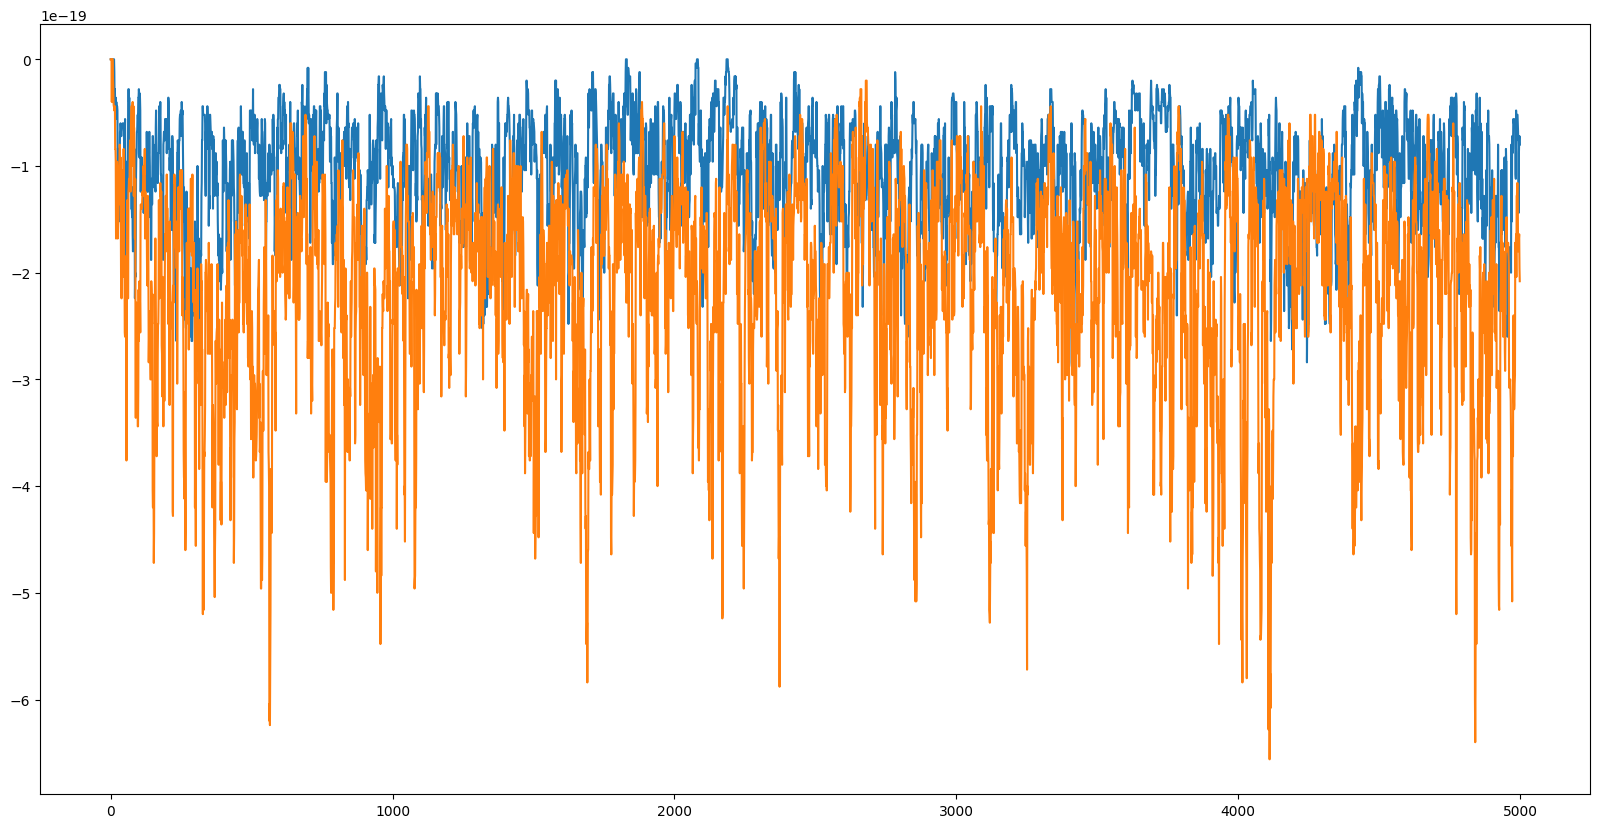

In [15]:
#2b)
#T-lav


t = 5000
T_low = 70
T_high = 350

V_1 = make_V_const(22, -4.0 * 10**(-21))
V_2 = make_V_const(33, -4.0 * 10**(-21))

_polymer, energy_vals1 = simulate_energy(init_polymer(22), t, V_1, T_low)
_polymer, energy_vals2 = simulate_energy(init_polymer(33), t, V_2, T_high)


# plt.title()
# plt.xlabel()
# plt.ylabel()
# plt.grid()
plt.plot(np.arange(t), energy_vals1)
plt.plot(np.arange(t), energy_vals2)
plt.gcf().set_size_inches(20, 10)
# plt.show()